# What do we need...

In [2]:
import re
import string

import swifter
import pandas as pd

from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

## Prepare data

In [ ]:
spanish_punct = string.punctuation + "¡¿«»"

def remove_stuff(text):
    return re.sub(r"(?<!\w)-|-(?!\w)|[{}]".format(re.escape(spanish_punct.replace("-", ""))), "", text)


def clean_lyrics(letra):
    cleaned = ''
    for text in letra.split('\n'):
        if text == '':
            continue
        text = re.sub(r'\[.+?\]', ' ', text) # remove whatever is between brackets
        text = re.sub(r'\((.+?)\)', r'\1', text) # keep what is between parentheses
        text = re.sub(r'\"(.+?)\"', r'\1', text) # keep what is between quotes
        text = re.sub(r'[\s]+', ' ', text) # spaces
        text = text.strip() # remove leading and trailing spaces
        text = text.lower() # lowercase
        cleaned += text + ' '
    cleaned = re.sub(r'\s+', ' ', cleaned) # remove multiple spaces
    cleaned = cleaned.strip() # remove leading and trailing spaces
    return ' '.join(remove_stuff(tok) for tok in cleaned.split(' '))  # remove punctuation and special characters, e.g.: mierda! -> mierda

# Spanish lyrics dataset
df = pd.read_csv('c:/Users/rmessina/Eli/data/song_lyrics_es_1950_2020.csv', encoding='utf8')

display(f"Loaded {len(df)} rows from the dataset")
display("Cleaning lyrics...")
# Apply multiprocessing to the DataFrame with a progress bar
df['cleaned_lyrics'] = df['lyrics'].swifter.apply(clean_lyrics)

# Remove NaN values from the 'cleaned_lyrics' column
initial_count = len(df)
df = df.dropna(subset=['cleaned_lyrics'])
final_count = len(df)
removed_count = initial_count - final_count
display(f"Removed {removed_count} rows with NaN values from 'cleaned_lyrics'.")

df.to_csv('c:/Users/rmessina/Eli/data/song_lyrics_es_1950_2020_cleaned_final.csv', encoding='utf8', index=False)

# about 5-6 minutes to run

'Loaded 275059 rows from the dataset'

'Cleaning lyrics...'

Pandas Apply:   0%|          | 0/275059 [00:00<?, ?it/s]

"Removed 0 rows with NaN values from 'cleaned_lyrics'."

# First, let's create topic model using kmeans

In [ ]:
# convert the lyrics to vectors
embedding_model = SentenceTransformer("hiiamsid/sentence_similarity_spanish_es")

topic_model = BERTopic(embedding_model=embedding_model, language="spanish")

# umap for dimensionality reduction
umap_model = UMAP(n_components=5, random_state=42)
# kmeans for clustering, note: param is still called `hdbscan_model` in BERTopic
# using 32 clusters, it is more than the number of genres and also decades
n_clusters = 32
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="spanish",
    umap_model=umap_model,
    hdbscan_model=kmeans_model  # note: param is still called `hdbscan_model`
)

docs = df['cleaned_lyrics'].tolist()
topics, probs = topic_model.fit_transform(docs)

# Save the model
topic_model.save(f"c:/Users/rmessina/Eli/models/hiiamsid_bertopic_kmeans{n_clusters}_umap_spanish_lyrics")

topic_model.visualize_topics()

# takes 45-50min!


2025-05-07 13:06:09,855 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


## TODO: see the correlations between the topics and the annotations we have: decade, tag and views
## also regroup based on overlap

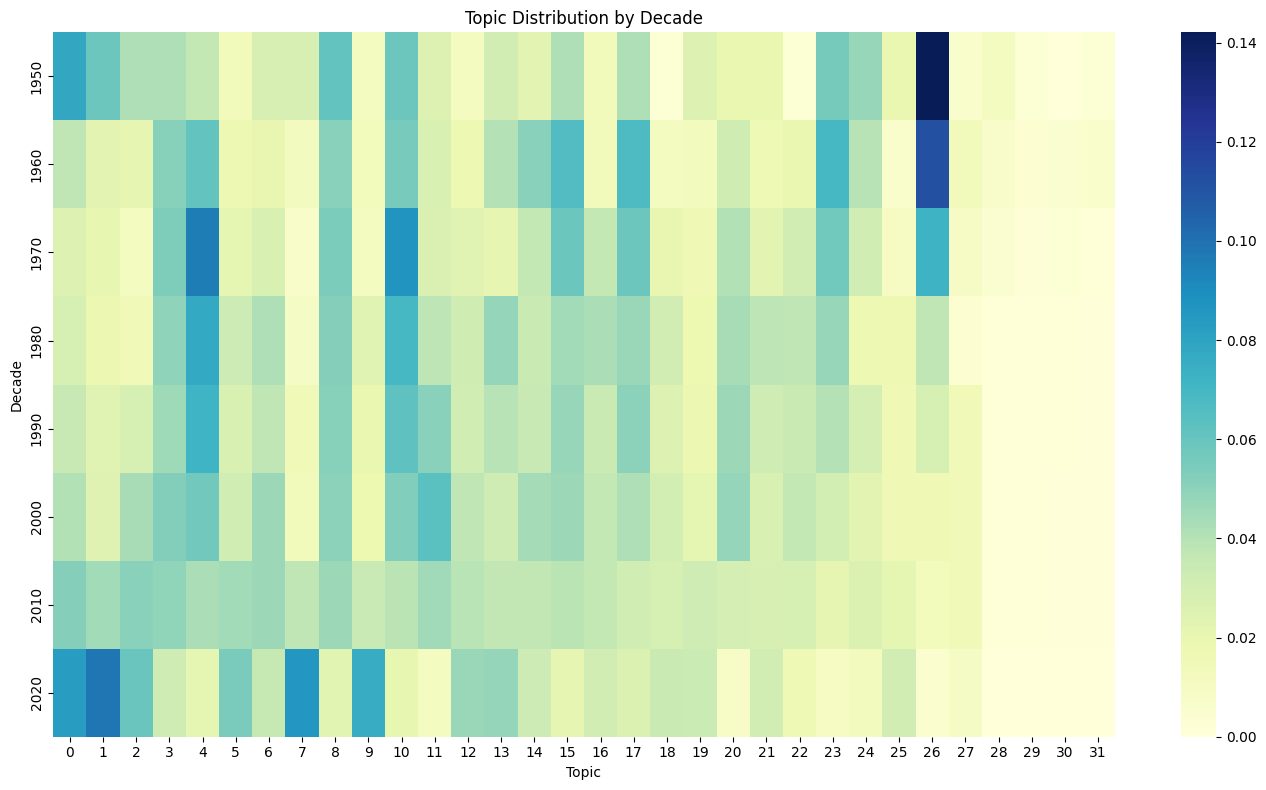

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add topics to your dataframe
df['topic'] = topics

# Create cross-tabulation of decade vs topics
decade_topic = pd.crosstab(df['decade'], df['topic'])

# Normalize by decade to get percentages
decade_topic_norm = decade_topic.div(decade_topic.sum(axis=1), axis=0)

# Heatmap visualization
plt.figure(figsize=(14, 8))
sns.heatmap(decade_topic_norm, cmap="YlGnBu", annot=False)
plt.title('Topic Distribution by Decade')
plt.ylabel('Decade')
plt.xlabel('Topic')
plt.tight_layout()
plt.show()

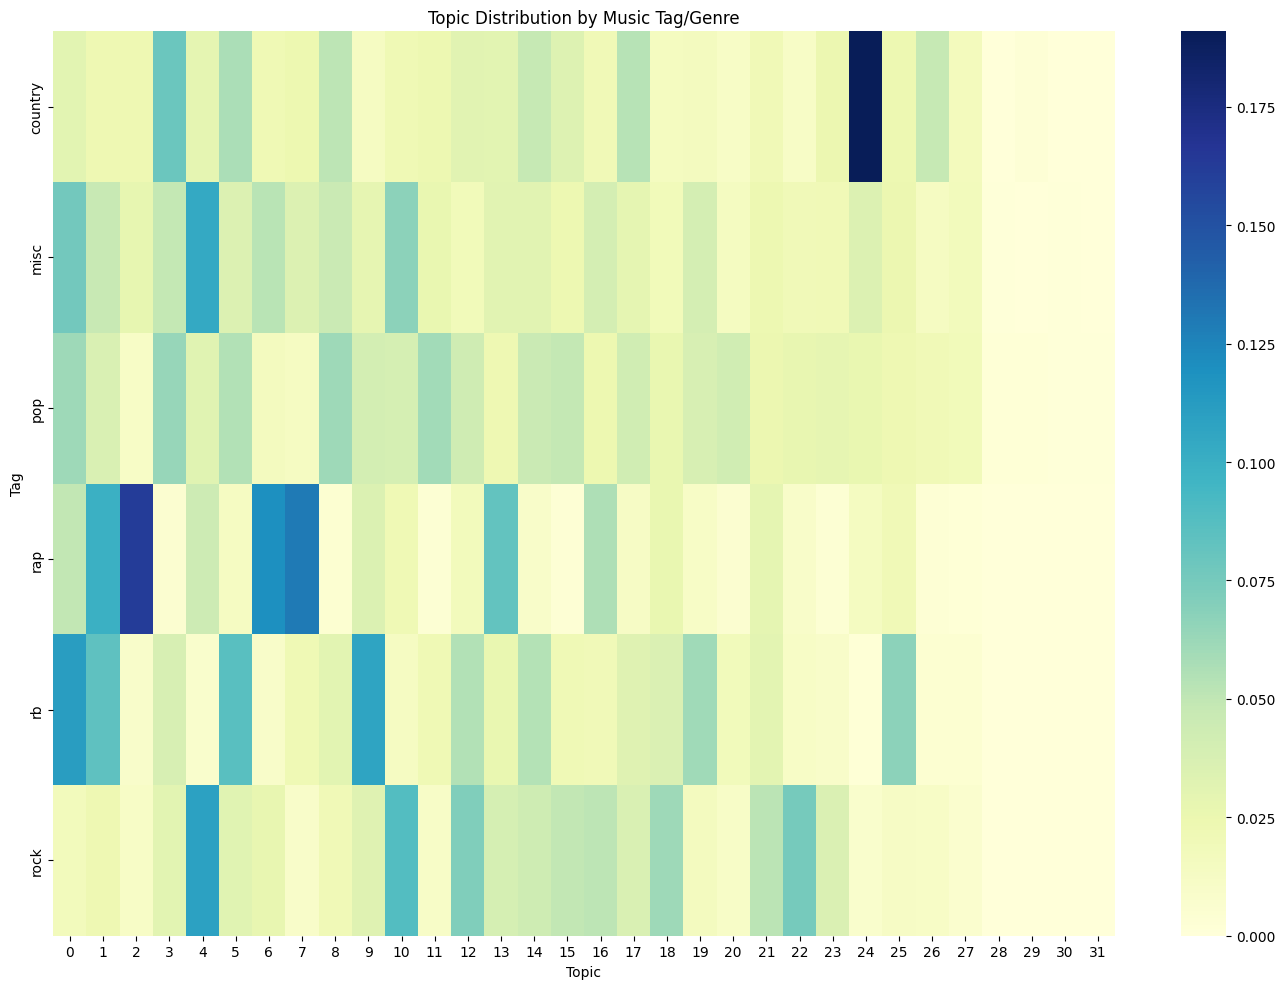

In [8]:
# Create cross-tabulation of tag vs topics
tag_topic = pd.crosstab(df['tag'], df['topic'])

# Normalize by tag
tag_topic_norm = tag_topic.div(tag_topic.sum(axis=1), axis=0)

# Heatmap for tag distribution
plt.figure(figsize=(14, 10))
sns.heatmap(tag_topic_norm, cmap="YlGnBu", annot=False)
plt.title('Topic Distribution by Music Tag/Genre')
plt.ylabel('Tag')
plt.xlabel('Topic')
plt.tight_layout()
plt.show()

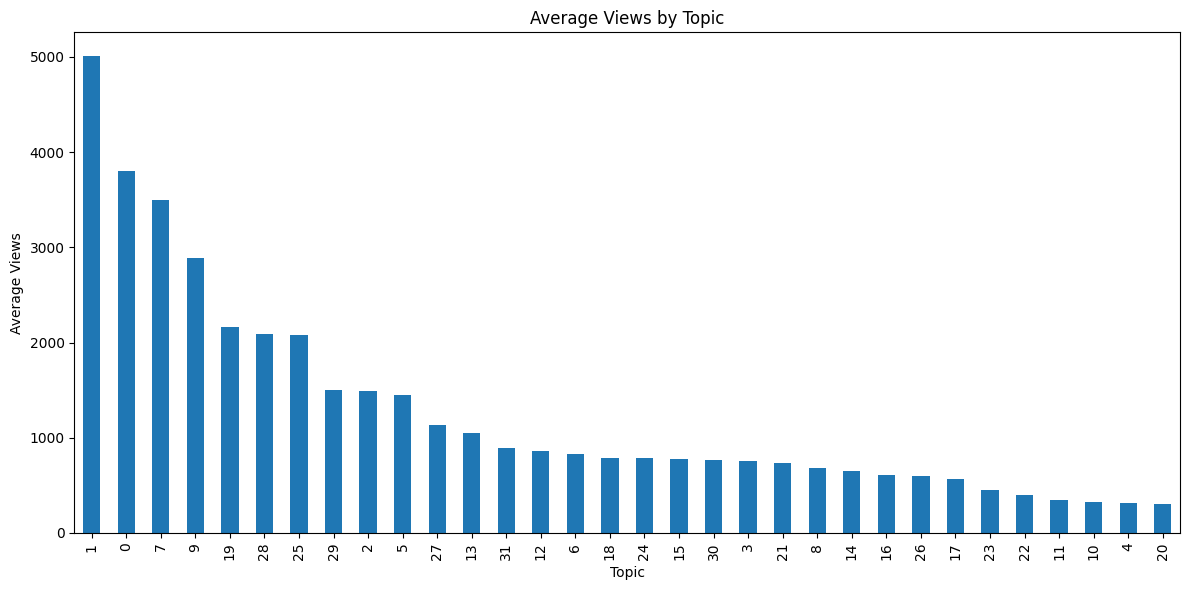

In [9]:
# Group by topic and calculate mean views
topic_views = df.groupby('topic')['views'].mean().sort_values(ascending=False)

# Visualize top topics by views
plt.figure(figsize=(12, 6))
topic_views.plot(kind='bar')
plt.title('Average Views by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Views')
plt.tight_layout()
plt.show()

In [12]:
# Get documents from topic 1
topic_id = 1  # The topic you're interested in
topic_docs = df[df['topic'] == topic_id]['cleaned_lyrics'].tolist()

# Display a few examples (e.g., first 5)
print(f"Sample lyrics from topic {topic_id}:")
for i, doc in enumerate(topic_docs[:5]):
    print(f"\nExample {i+1}:")
    print(doc[:200] + "..." if len(doc) > 200 else doc)  # Truncate long lyrics

Sample lyrics from topic 1:

Example 1:
you know los capos están ready las mamis están ready y en la calle estamos ready yeah yeah andamos ready los barrios están ready one two get ready come on oh oh oh oh rompe rompe rompe bien guillao ro...

Example 2:
conozco una muchacha y ella es fina tremendos cocos y también es linda a veces me la cojo en la cocina esta muchacha me chupa la pinga yo le dije dame tu bollo me dice negro loco tu no eres mi novio a...

Example 3:
auoooooooohhh oooouuuuhhhhhh uuuooohhhh walking out and looking back no moooore forget about how i loved befooore cuz my time is running out and the door is looking close so now the more ill wait the ...

Example 4:
letra de ven conmigo ft prince royce d-d-d-dy royce ive seen her walk at the club showing up her sexy flow dy sexy flow sexy flow thats right una chiquita caliente me enamoré de sus ojos de sus ojos y...

Example 5:
a yo k lo k oro 24 nikolodian en el remix de la tosting light esta totadoro si ta tosting light 

In [13]:
# Get the most representative documents for topic 1
representative_docs = topic_model.get_representative_docs(topic=1)

# Display them
print(f"Most representative lyrics for topic {topic_id}:")
for i, doc in enumerate(representative_docs[:5]):
    print(f"\nExample {i+1}:")
    print(doc[:200] + "..." if len(doc) > 200 else doc)

Most representative lyrics for topic 1:

Example 1:
oye mamá jajajaja tranquilo papá eto e’ merenglass urbano oye swift porque ella me llama a mí cuando ya no está contigo y dice que quiere salir sabe que yo soy tu amigo yo yo yo yo yo sé que ya tiene ...

Example 2:
fue un placer ya me voy gusto en conocerte para el otro jueves quisiera volver a hacerte si cambio los planes puede que no te conteste estaré con otra también quiere que la inyecte y tu pa salir activ...

Example 3:
ac3 on the track eh eh que se lo haga en la mañana eh yo me la como pa desayuno yeh antes de prenderme uno ah tengo que hacérselo bien duro yeh-yeh se pone ratchet eso me gusta ah ready pa hacer de to...


In [20]:
# Display songs with artist and title information
topic_songs = df[df['topic'] == topic_id][['artist', 'title', 'cleaned_lyrics', 'views', 'decade', 'tag']]
topic_songs_sorted = topic_songs.sort_values('views', ascending=False)

print(f"Top songs from topic {topic_id} by views:")
for i, (_, row) in enumerate(topic_songs_sorted.head(5).iterrows()):
    print(f"\n{i+1}. {row['artist']} - {row['title']} ({row['decade']}, {row['tag']}, {row['views']} views)")
    print(row['cleaned_lyrics'][:100] + "..." if len(row['cleaned_lyrics']) > 100 else row['cleaned_lyrics'])

Top songs from topic 1 by views:

1. Luis Fonsi & Daddy Yankee - Despacito Remix (2010, pop, 23351415 views)
comin over in my direction so thankful for that its such a blessin yeah turn every situation into he...

2. J Balvin & Willy William - Mi Gente (2010, pop, 1558734 views)
si el ritmo te lleva a mover la cabeza ya empezamos como es mi música no discrimina a nadie así que ...

3. Bad Bunny, Jowell & Randy & engo Flow - Safaera (2020, pop, 990457 views)
bla bla bla bla bla bla ey yo yo yo yo yo yo yo yah lalalalalalala blow blow lalalalalalala diablo q...

4. Romeo Santos - Odio (2010, pop, 953790 views)
yeah yeah envy is a sign of admiration hate it’s the epitome of destruction tal parece que mi amor c...

5. J Balvin & Willy William - Mi Gente Beyoncé Remix (2010, pop, 652032 views)
si el ritmo te lleva a mover la cabeza ya empezamos cómo es mi música no discrimina a nadie así que ...


In [ ]:
# Try using get_topic_info()
topic_info = topic_model.get_topic_info()
print(topic_info)  # This should include counts in a column

# The Count column should contain the sizes
topic_sizes = topic_info[['Topic', 'Count']]
print(topic_sizes)

    Topic  Count                             Name  \
0       0  15194                   0_la_que_me_te   
1       1  14213                   1_la_me_no_que   
2       2  13318                    2_el_de_la_en   
3       3  12509                   3_no_te_que_me   
4       4  12005                    4_de_la_el_en   
5       5  11851                   5_no_que_te_me   
6       6  11772                   6_de_el_la_que   
7       7  11642                    7_la_el_en_no   
8       8  11631                 8_amor_tu_mi_que   
9       9  11000                    9_oh_no_ah_me   
10     10  10938                   10_de_el_la_en   
11     11  10922                  11_tu_que_te_mi   
12     12  10853                  12_no_que_me_de   
13     13  10780                  13_la_de_el_que   
14     14  10137                  14_no_que_te_me   
15     15  10106                  15_de_el_que_en   
16     16   9595                  16_que_de_no_la   
17     17   9322                  17_que_no_te

In [ ]:
import numpy as np

# Get the coordinates from topic model
topic_vis = topic_model.visualize_topics()

# Extract coordinates from the visualization
# Different versions of BERTopic may require slightly different approaches
# Method 1:
coordinates = np.array([topic_vis.data[0]['x'], topic_vis.data[0]['y']]).T


(32, 2)


In [45]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Apply hierarchical clustering
n_groups = 7  # Number of groups you want to create (from the image aboove, we see 7 clusters)
clustering = AgglomerativeClustering(n_clusters=n_groups)
topic_cluster = clustering.fit_predict(coordinates)

# Display the grouping results
print(topic_cluster)


[1 1 4 2 4 2 4 1 0 2 3 2 6 6 5 0 5 5 5 1 2 6 0 3 4 6 3 0 0 0 0 0]


merged_topic
0    33848
1    49175
2    54248
3    21433
4    43342
5    37279
6    35734
Name: count, dtype: int64


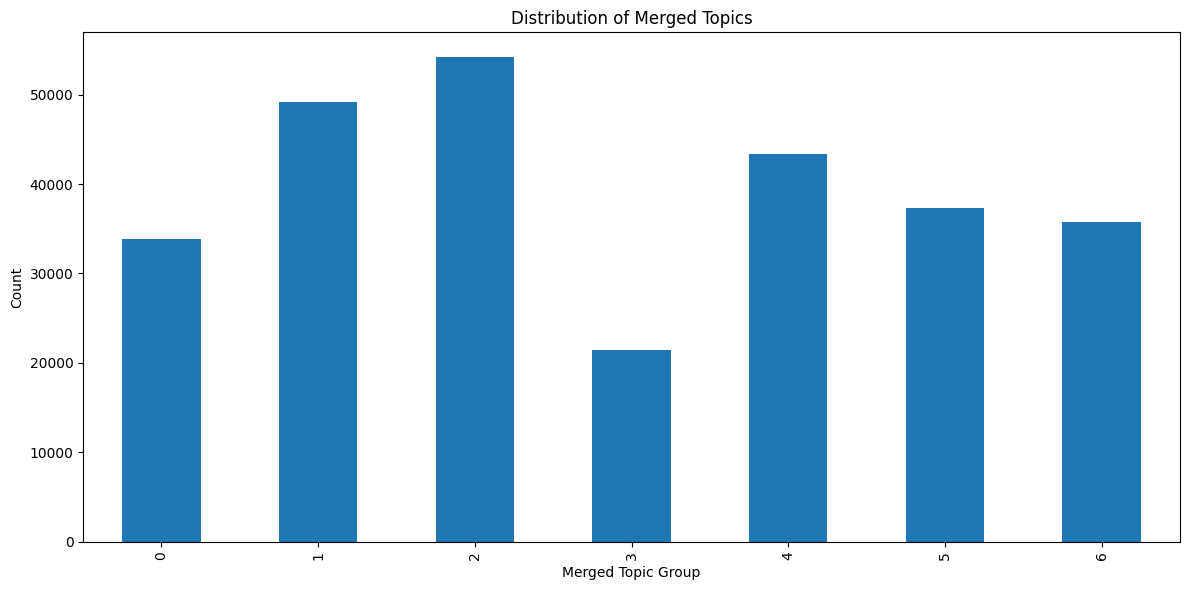

In [46]:
# merge the topics into groups
topic_mapping = {}
for group_id, topic in enumerate(topic_cluster):
    topic_mapping[group_id] = topic

# Create a new column with merged topics
df['merged_topic'] = df['topic'].map(lambda x: topic_mapping.get(x, -1))

# Analyze the new merged topics
merged_topic_counts = df['merged_topic'].value_counts().sort_index()
print(merged_topic_counts)

# Visualize distribution of merged topics
plt.figure(figsize=(12, 6))
merged_topic_counts.plot(kind='bar')
plt.title('Distribution of Merged Topics')
plt.xlabel('Merged Topic Group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

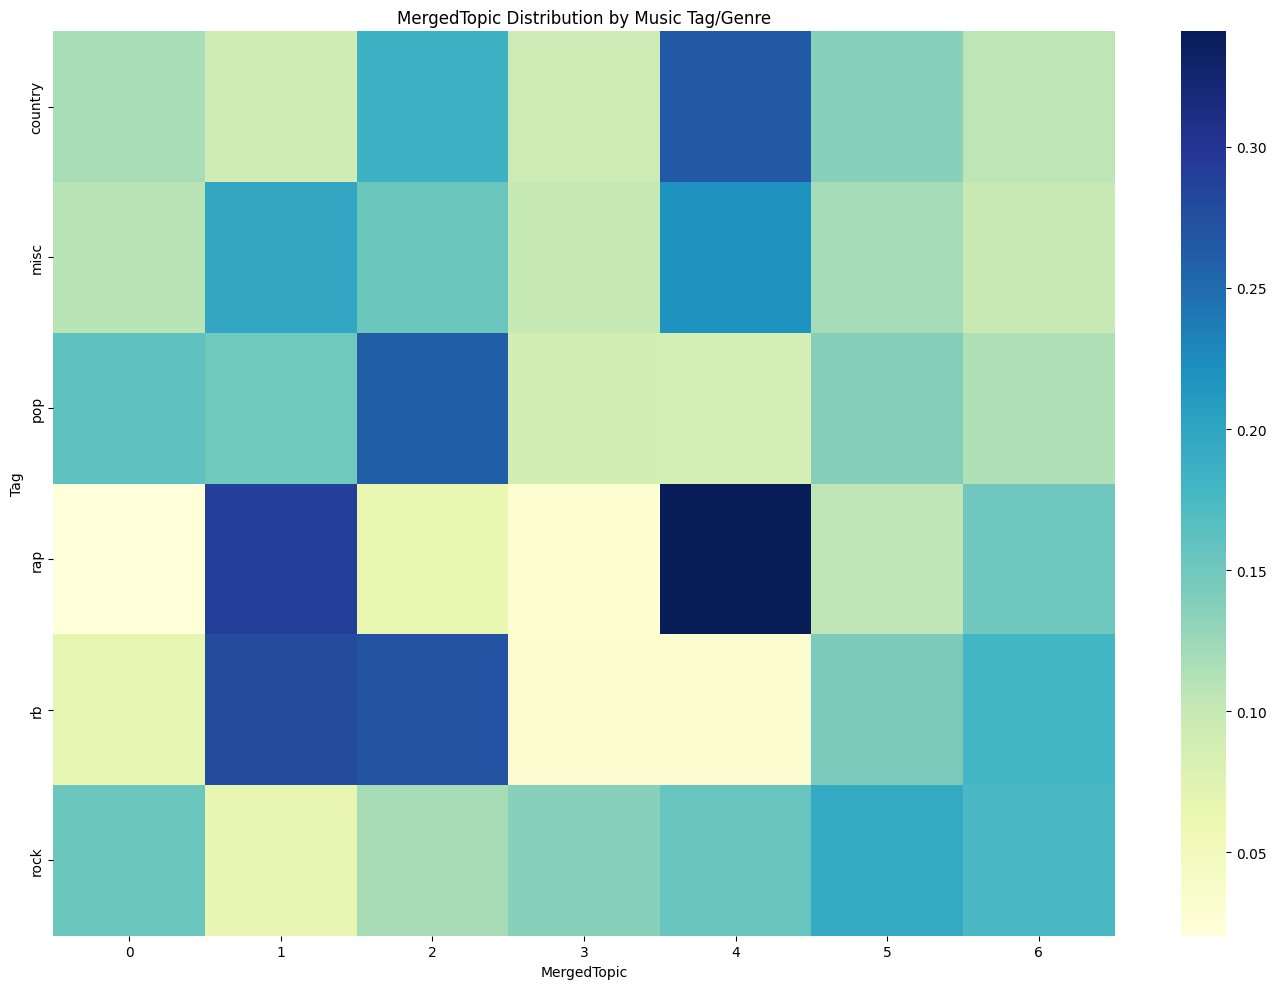

In [47]:
# Create cross-tabulation of tag vs topics
tag_topic = pd.crosstab(df['tag'], df['merged_topic'])

# Normalize by tag
tag_topic_norm = tag_topic.div(tag_topic.sum(axis=1), axis=0)

# Heatmap for tag distribution
plt.figure(figsize=(14, 10))
sns.heatmap(tag_topic_norm, cmap="YlGnBu", annot=False)
plt.title('MergedTopic Distribution by Music Tag/Genre')
plt.ylabel('Tag')
plt.xlabel('MergedTopic')
plt.tight_layout()
plt.show()

It seems the automatically found topics do not match the genres nor the decades.
Could be that the embedding model is not adapted to lyrics (lots of repetition, non-words such as yeah, ooohhh, etc.)
